In [2]:

import pandas as pd
import numpy as np
#import prospr as pr
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sns
import random
import csv
from collections import Counter
import itertools


In [3]:
class Protein:
  def __init__(self, sequence , folds=[]):
    self.sequence = sequence
    self.hash_fold = folds
    self.loc_list = []
    self.score = (0,0)
    self.collisions = 0
    self.bonds = 0

    self.update_loc_list()
    self.update_score()

  def update_loc_list(self):

    self.loc_list = []
    moves = self.hash_fold

    # Setup storage of the amino positions.
    cur_pos = [0,0]
    self.loc_list.append((0,0))
    # Save the coordinates of the aminos in order.
    for move in moves:
        cur_pos[abs(move) - 1] += move // abs(move)
        self.loc_list.append(tuple(cur_pos))

    pass

  def random_fold(self):
    self.hash_fold = []
    for _ in range(len(self.sequence)-1) :
        direction = np.random.choice([-2, -1, 1, 2])
        self.hash_fold.append(direction)
    self.update_loc_list()
    pass

  def set_hash(self, index, direction, update = True):
    self.hash_fold[index] = direction

    if update:
      self.update_loc_list()
      self.update_score()
    pass

  def mutate(self):
    index = np.random.randint(0,len(self.hash_fold))
    new_number = np.random.choice([-2, -1, 1, 2])
    self.hash_fold[index] = new_number

    self.update_loc_list()
    self.update_score()
    pass

  def remove_back(self):
    for i in range(1, len(self.hash_fold)):
        # Check if the current element is the negative of the previous element
        if self.hash_fold[i] == -self.hash_fold[i - 1]:
            # Modify the current element to a different value from the possible options
            while True:
                new_value = np.random.choice([-2, -1, 1, 2])
                if new_value != -self.hash_fold[i - 1]:
                    self.hash_fold[i] = new_value
                    break
    self.update_loc_list()
    pass

  def get_bonds(self):
    bonds = 0
    for i, loc in enumerate(self.loc_list):
      if self.sequence[i] == 'H':
         x,y = loc
         directions = [(1,0), (-1,0), (0,1), (0,-1)]
         neighbours = [(x + dx, y + dy) for dx, dy in directions]
         for neighbour in neighbours:
            if self.find_neighbours(neighbour, self.sequence[i+2:] ,self.loc_list[i+2:]):
               bonds += 1
    self.bonds = bonds
    return bonds

  def find_neighbours(self, loc, changed_seq, changed_loc):
    aminos = []
    for i, item in enumerate(changed_loc):
      if item == loc:
        if changed_seq[i] == 'H':
          aminos.append(i)
    if len(aminos) > 0:
       return True
    else:
       return False

  def get_pairs(self):
    pairs = []
    for i, loc in enumerate(self.loc_list):
      if self.sequence[i] == 'H':
         x,y = loc
         directions = [(1,0), (-1,0), (0,1), (0,-1)]
         neighbours = [(x + dx, y + dy) for dx, dy in directions]
         for neighbour in neighbours:
            if self.find_neighbours(neighbour, self.sequence[i+2:], self.loc_list[i+2:]):
               pairs.append((loc,neighbour))
    return pairs

  def get_collision(self):
    collision_count = 0
    visited_positions = set()

    for coordinate in self.loc_list:
        if coordinate in visited_positions:
            collision_count += 1
        else:
            visited_positions.add(coordinate)

    self.collisions = collision_count
    return collision_count

  def update_score(self):
    self.get_collision()
    self.get_bonds()
    self.score = (self.bonds, self.collisions)
    pass

  def __str__(self):
    return f"Protein: {len(self.sequence)}\nSequence: {self.sequence}\nFolds: {self.hash_fold}"



In [4]:
def get_ordered_positions(protein):
    """
    Fetch the positions of the currently folded amino chain in order of
    placement.
    """
    # Fetch done moves and the aminos used so far.
    moves = protein.hash_fold
    aminos = protein.sequence[: len(moves) + 1]

    # Setup storage of the amino positions.
    cur_pos = np.array([0 for _ in range(2)], dtype=np.int64)
    positions = np.array([*cur_pos, aminos[0]])

    # Save the coordinates of the aminos in order.
    for amino, move in zip(aminos[1:], moves):
        cur_pos[abs(move) - 1] += move // abs(move)
        positions = np.vstack((positions, np.array([*cur_pos, amino])))

    return positions


In [5]:
def hc_c(protein, max_iterations):
    data = []
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0,best_fitness])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        if mutated_protein.collisions <= best_fitness:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            best_solution = current_protein.hash_fold
            best_fitness = current_protein.collisions
            data.append([_, best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [6]:
def hc_b(protein, max_iterations):
    data = []
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_bonds()
    best_solution = current_protein.hash_fold
    data.append([0,best_fitness])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        if mutated_protein.bonds >= best_fitness:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            best_solution = current_protein.hash_fold
            best_fitness = current_protein.bonds
            data.append([_, best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [7]:
def hc_c_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    current_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.collisions in fitness_dict:
            fitness_dict[mutated_protein.collisions] += 1
        else:
            fitness_dict.setdefault(mutated_protein.collisions, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.collisions] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.collisions

            if current_fitness <= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.collisions 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [8]:
def hc_b_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_bonds()
    current_fitness = current_protein.get_bonds()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.bonds in fitness_dict:
            fitness_dict[mutated_protein.bonds] += 1
        else:
            fitness_dict.setdefault(mutated_protein.bonds, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.bonds] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.bonds

            if current_fitness >= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.bonds 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [ ]:
def mhc(protein, max_iterations):
    data = []
    fitnesslist = []
    fitnessdict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    fitnesslist.append(current_protein.score)
    fitnessdict[current_protein.score] = current_protein.hash_fold

    data.append([0,fitnesslist])

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        dominated = False
        exists = False
        old_scores = []

        for set in fitnesslist:
            if mutated_protein.collisions >= set[0] and mutated_protein.bonds <= set[0] and not (mutated_protein.score == set):
                dominated = True
                break
            if mutated_protein.collisions <= set[0] and mutated_protein.bonds >= set[0]:
                old_scores.append(set)
                if mutated_protein.score == set:
                    exists = True

        if not dominated:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            fitnessdict[current_protein.score] = current_protein.hash_fold
            if not exists:
                for set in old_scores:
                    del fitnessdict[set]
                    fitnesslist.remove(set)
                fitnesslist.append(current_protein.score)
                
            data.append([_, fitnesslist])

    return current_protein, fitnessdict, fitnesslist, data

In [ ]:
def hc_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    current_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(max_iterations):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.collisions in fitness_dict:
            fitness_dict[mutated_protein.collisions] += 1
        else:
            fitness_dict.setdefault(mutated_protein.collisions, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.collisions] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.collisions

            if current_fitness <= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.collisions 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [9]:
def random_sequence(length, HP = 0.5):
    sequence = ""
    for i in range(length):
        if random.random() < HP:
            sequence += "P"
        else:
            sequence += "H"
    return sequence

In [10]:
# numbers = range(20, 201, 20)

# combined = []

# for number in numbers:
#     data = [] 
#     for i in range(5):
#         protein = Protein(random_sequence(number))
#         protein.random_fold()
#         data.append(protein)
#     df = pd.DataFrame(data)
#     combined.append(df)

# # Create a single DataFrame from all generated DataFrames
# Database = pd.concat(combined)

# print(Database)

In [11]:
#Database.to_csv("Database.csv")

In [12]:
# Open the CSV file in read mode
with open('Database.csv', 'r') as csvfile:
    # Create a DictReader object
    reader = csv.DictReader(csvfile)

    # Convert each row to a dictionary
    data = []
    for row in reader:
        data.append(row)

    # Convert the list of dictionaries to a DataFrame
    Database = pd.DataFrame(data)

In [13]:
results = []
resultsFFA = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = hc_c(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])

    current_protein, best_solution, best_fitness, data = hc_c_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(protein.sequence)) + " iter " + str(_))

20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
40 iter 5
40 iter 6
40 iter 7
40 iter 8
40 iter 9
60 iter 10
60 iter 11
60 iter 12
60 iter 13
60 iter 14
80 iter 15
80 iter 16
80 iter 17
80 iter 18
80 iter 19
100 iter 20
100 iter 21
100 iter 22
100 iter 23
100 iter 24
120 iter 25
120 iter 26
120 iter 27
120 iter 28
120 iter 29
140 iter 30
140 iter 31
140 iter 32
140 iter 33
140 iter 34
160 iter 35
160 iter 36
160 iter 37
160 iter 38
160 iter 39
180 iter 40
180 iter 41
180 iter 42
180 iter 43
180 iter 44
200 iter 45
200 iter 46
200 iter 47
200 iter 48
200 iter 49


In [14]:
df = pd.DataFrame(results)
df.to_json("Collisions.json")

In [15]:
dfFFA = pd.DataFrame(resultsFFA)
dfFFA.to_json("Collisions_FFA.json")

In [16]:
results = []
resultsFFA = []

for _, protein_data in Database.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = hc_b(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])

    current_protein, best_solution, best_fitness, data = hc_b_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(protein.sequence)) + " iter " + str(_))

20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
40 iter 5
40 iter 6
40 iter 7
40 iter 8
40 iter 9
60 iter 10
60 iter 11
60 iter 12
60 iter 13
60 iter 14
80 iter 15
80 iter 16
80 iter 17
80 iter 18
80 iter 19
100 iter 20
100 iter 21
100 iter 22
100 iter 23
100 iter 24
120 iter 25
120 iter 26
120 iter 27
120 iter 28
120 iter 29
140 iter 30
140 iter 31
140 iter 32
140 iter 33
140 iter 34
160 iter 35
160 iter 36
160 iter 37
160 iter 38
160 iter 39
180 iter 40
180 iter 41
180 iter 42
180 iter 43
180 iter 44
200 iter 45
200 iter 46
200 iter 47
200 iter 48
200 iter 49


In [17]:
# df = pd.DataFrame(results)
# df.to_json("Bonds.json")

In [18]:
# dfFFA = pd.DataFrame(resultsFFA)
# dfFFA.to_json("Bonds_FFA.json")

In [37]:
Bondsdf = pd.read_json("Bonds.json")
BondsdFFA = pd.read_json("Bonds_FFA.json")


In [22]:
iterations = [i[0] for i in dfFFA[3][0]]
current_solutions = [i[1] for i in dfFFA[3][0]]
best_solutions = [i[2] for i in dfFFA[3][0]]

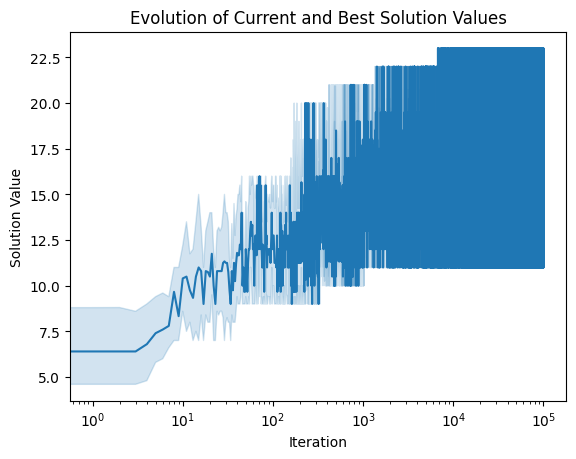

In [41]:
df = pd.DataFrame({'Iteration': [i[0] for i in Bondsdf[3][0]], 'Best Solution': [i[1] for i in Bondsdf[3][0]]})
dfFFA = pd.DataFrame({'Iteration': [i[0] for i in BondsdFFA[3][0]], 'Current Solution': [i[1] for i in BondsdFFA[3][0]], 'Best Solution': [i[2] for i in BondsdFFA[3][0]]})

combined_data = []
for j in range(5):
    df = pd.DataFrame({'Iteration': [i[0] for i in Bondsdf[3][j]], 'Best Solution': [i[1] for i in Bondsdf[3][j]]})
    combined_data.append(df)

# Combine the DataFrames into a single DataFrame
df = pd.concat(combined_data, ignore_index=True)

combined_dataFFA = []
for j in range(5):
    dfFFA = pd.DataFrame({'Iteration': [i[0] for i in BondsdFFA[3][j]], 'Current Solution': [i[1] for i in BondsdFFA[3][j]], 'Best Solution': [i[2] for i in BondsdFFA[3][j]]})
    combined_dataFFA.append(dfFFA)

# Combine the DataFrames into a single DataFrame
dfFFA = pd.concat(combined_dataFFA, ignore_index=True)

# Create line plots for current and best solutions
#sns.lineplot(x='Iteration', y='Current Solution', data=df)
#sns.lineplot(x='Iteration', y='Best Solution', data=df)
sns.lineplot(x='Iteration', y='Best Solution', data=dfFFA)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Solution Value')
plt.xscale('log')
plt.title('Evolution of Current and Best Solution Values')

# Show the plot
plt.show()

,0,1,2,3
0,"{'bonds': 10, 'collisions': 13, 'hash_fold': [...","[2, -1, 1, 1, -1, -2, -1, 2, -2, 1, 2, -1, -2,...",10,"[[0, 5], [0, 5], [1, 5], [5, 5], [6, 5], [8, 5..."
1,"{'bonds': 21, 'collisions': 12, 'hash_fold': [...","[1, -1, -2, 2, -1, -2, 2, 1, 2, 1, -2, -1, -1,...",21,"[[0, 7], [0, 7], [1, 7], [2, 8], [3, 10], [4, ..."
2,"{'bonds': 16, 'collisions': 11, 'hash_fold': [...","[-1, 1, -2, 2, 2, -1, -2, -2, -2, 1, 2, -1, 2,...",16,"[[0, 4], [0, 4], [1, 4], [2, 4], [3, 5], [7, 6..."
3,"{'bonds': 13, 'collisions': 14, 'hash_fold': [...","[2, -2, -1, 1, -1, 1, -1, 1, 1, 2, -1, -2, 1, ...",13,"[[0, 11], [1, 11], [2, 11], [3, 11], [4, 12], ..."
4,"{'bonds': 13, 'collisions': 10, 'hash_fold': [...","[-2, 2, -2, -1, 2, 1, -1, 1, -2, 2, -1, 1, 1, ...",13,"[[0, 5], [0, 5], [1, 5], [2, 5], [3, 5], [4, 5..."
5,"{'bonds': 43, 'collisions': 31, 'hash_fold': [...","[-1, 2, 1, 1, -1, -2, -1, -1, 1, 2, -2, 1, -1,...",43,"[[0, 20], [0, 20], [1, 20], [6, 20], [7, 20], ..."
6,"{'bonds': 68, 'collisions': 26, 'hash_fold': [...","[-1, 2, -2, -2, 2, 2, -2, -1, -2, 2, 2, 1, -2,...",68,"[[0, 21], [0, 21], [1, 27], [2, 27], [4, 28], ..."
7,"{'bonds': 33, 'collisions': 27, 'hash_fold': [...","[-1, -2, -1, 1, 1, 2, -2, -1, 2, -1, 1, -1, 2,...",33,"[[0, 13], [1, 14], [3, 14], [4, 14], [7, 18], ..."
8,"{'bonds': 33, 'collisions': 25, 'hash_fold': [...","[-2, 1, 2, -1, 1, 2, 1, -2, -1, 2, -2, -2, -1,...",33,"[[0, 7], [1, 10], [2, 16], [3, 16], [4, 17], [..."
9,"{'bonds': 43, 'collisions': 26, 'hash_fold': [...","[-2, -1, -1, -2, 2, 2, -2, -1, -2, 2, -2, 2, 1...",43,"[[0, 12], [0, 12], [1, 15], [2, 20], [4, 20], ..."


In [34]:
iterations = [i[0] for i in Bondsdf[3][0]]
best_solutions = [i[1] for i in Bondsdf[3][0]]